In [525]:
import os
import sys

import torch
# from torch import nn, optim
from torch.nn import functional as FeatureAlphaDropout
# import torch.nn as nn
sys.path.append(os.path.realpath('../'))
import numpy as np
# import pickle as pkl
# from datasets import make_dataloader
from bitrap.modeling import make_model
# from bitrap.engine import build_engine

from bitrap.utils.logger import Logger
# import logging
# import argparse
from configs import cfg
from termcolor import colored 
from sort import *

from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt


In [526]:
%matplotlib inline

In [527]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [528]:
class Person:
    def __init__(self, id):
        self.id = id
        # Form is x1, y1, x2, y2, id
        self.frames = []
    
    def add_frame(self, frame):
        self.frames.append(frame)
        return len(self.frames) >= 15

    def get_prediction_frames(self):
        frames = self.frames[:15]
        self.frames.pop(0)
        return frames

    def __len__(self):
        return len(self.frames)

    def __str__(self):
        return f"Person {self.id}, with {len(self.frames)} frames"

In [529]:
cfg.merge_from_file("../configs/bitrap_np_JAAD.yml")
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [530]:
model = make_model(cfg)
model = model.to(cfg.DEVICE)
checkpoint = "../" + cfg.CKPT_DIR + "best.pth"

if os.path.isfile(checkpoint):
    model.load_state_dict(torch.load(checkpoint))
    print(colored('Loaded checkpoint:{}'.format(checkpoint), 'blue', 'on_green'))
else:
    print(colored('The cfg.CKPT_DIR id not a file: {}'.format(checkpoint), 'green', 'on_red'))

Loaded checkpoint:../checkpoints/JAAD_checkpoints/goal_cvae_checkpoints/best.pth


In [531]:
images = [f"../data/JAAD/images/video_0005/000{i + 46}.png" for i in range(15)]
# images = [f"../image_{i}.png" for i in range(15)]

yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
mot_tracker = Sort() 


dataloader = DataLoader(images, num_workers=1)
print(len(images))
_min = np.array([0,0,0,0])[None, :]
_max = np.array([1920, 1080, 1920, 1080])[None, :]

Using cache found in C:\Users\sonor/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-11-7 Python-3.8.13 torch-1.12.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


15


In [532]:
def predict(model, input_x, cur_pos = None):
    gt_goal = None
    cur_pos = input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM] if cur_pos is None else cur_pos
    batch_size, seg_len, _ = input_x.shape

    h_x = model.encoder(input_x, None)
    Z, KLD = model.gaussian_latent_net(h_x, input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM], None, z_mode=False)
    enc_h_and_z = torch.cat([h_x.unsqueeze(1).repeat(1, Z.shape[1], 1), Z], dim=-1)
    pred_goal = model.goal_decoder(enc_h_and_z)
    # dec_h = enc_h_and_z if model.cfg.DEC_WITH_Z else h_x

    pred_goal = model.goal_decoder(enc_h_and_z)

    # dec_h = enc_h_and_z if model.cfg.DEC_WITH_Z else h_x
    pred_traj = model.pred_future_traj(h_x, pred_goal)
    cur_pos = input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM] if cur_pos is None else cur_pos.unsqueeze(1)
    pred_goal = pred_goal + cur_pos
    pred_traj = pred_traj + cur_pos.unsqueeze(1)

    return pred_traj, pred_goal



In [533]:
def get_image(imgs):
    results = yolo(imgs)
    overall_data = []
    for j in range(len(results.pandas().xyxy)):
        df = results.pandas().xyxy[j]
        bounding_boxes_pedestrians = df.loc[df['class'] == 0]
        data = []

        reconstruction = np.array([[0., 0., 0., 0.]])

        # TODO: FOR NOW, break statement exists so it only predicts one person... This will need to change
        for i, row in bounding_boxes_pedestrians.iterrows():
            bbox = np.array([[row['xmin'], row['ymin'], row['xmax'], row['ymax']]])
            reconstruction[..., [0, 1]] = bbox[..., [0, 1]]
            bbox[..., [2, 3]] = bbox[..., [2, 3]] - bbox[..., [0, 1]]
            reconstruction[..., [2, 3]] = bbox[..., [2, 3]] / 2
            bbox[..., [0, 1]] += bbox[..., [2, 3]]/2
            
            

            # NOTE Normalize bbox
            # W, H  = all_resolutions[i][0]
            # _min comes from MIN_BBOX in config
            # _max comes from MAX_BBOX in config

            bbox = (bbox - _min) / (_max - _min)
            
            data.append(bbox[0])
        overall_data.append(data)
            
            
    overall_data = np.array(overall_data)
    
    # max_val = np.max(np.abs(data))
    # min_val = np.min(data)



    return torch.FloatTensor(overall_data), reconstruction

In [534]:
cv_image = cv2.imread(f"../data/JAAD/images/video_0005/00046.png")

ids_to_update = []
ids = {}
results = yolo(images)
for j in results.pred:

    detections = j.cpu().numpy()
    people = []


    for i, prediction in enumerate(detections):
        if prediction[5] == 0:
            people.append(prediction)
    if len(people) > 0:
    # detections = np.where(detections[i][5] == 0 for i in range(len(detections)))
        track_bbs_ids = mot_tracker.update(np.array(people))



        for j, coords in enumerate(track_bbs_ids.tolist()):
            x1, y1, x2, y2, name_idx = int(coords[0]), int(coords[1]), int(coords[2]), int(coords[3]), int(coords[4])
            name = f"ID: {name_idx}"

            if name_idx not in ids.keys():
                ids[name_idx] = Person(id)                    
            
            if ids[name_idx].add_frame(coords):
                ids_to_update.append(name_idx)
            
            cv2.rectangle(cv_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
            # cv2.putText(frame, name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

In [535]:
reconstruction = np.array([[0., 0., 0., 0.]])

for person_id in ids_to_update:
    data_to_predict_on = []

    bounding_boxes = ids[person_id].get_prediction_frames()
    
    for j, row in enumerate(bounding_boxes):
        bbox = np.array([[row[0], row[1], row[2], row[3]]])
        reconstruction[..., [0, 1]] = bbox[..., [0, 1]]
        bbox[..., [2, 3]] = bbox[..., [2, 3]] - bbox[..., [0, 1]]
        reconstruction[..., [2, 3]] = bbox[..., [2, 3]] / 2
        bbox[..., [0, 1]] += bbox[..., [2, 3]]/2
        
        

        # NOTE Normalize bbox
        # W, H  = all_resolutions[i][0]
        # _min comes from MIN_BBOX in config
        # _max comes from MAX_BBOX in config

        bbox = (bbox - _min) / (_max - _min)
        data_to_predict_on.append(bbox[0])
    
    # Should have length greater than 15, due to it only being for looped if that holds true
    prediction_data = torch.FloatTensor(np.array(data_to_predict_on[:15])).to(device)
    prediction_data = prediction_data.unsqueeze(0)
    cur_pos = prediction_data[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM]
    pred_traj, pred_goal = predict(model, prediction_data, cur_pos=prediction_data[-1, :cfg.MODEL.DEC_OUTPUT_DIM])
    pred_goal = pred_goal.detach().to('cpu').numpy() * (_max - _min) + _min
    pred_traj = pred_traj.detach().to('cpu').numpy() * (_max - _min) + _min
    for traj in pred_traj:
        for i, frames in enumerate(traj):
            box = frames[0]
            box[0] -= reconstruction[0][2]
            box[1] -= reconstruction[0][3]
            box[2] += reconstruction[0][0]
            box[3] += reconstruction[0][1]


            if i < len(traj) - 1:
                
            # Compute the center of each bounding box
                centerX = box[2] + box[0] / 2
                centerY = box[3] + box[1] / 2

                nextBox = traj[i + 1][0]
                nextCenterX = nextBox[2] + nextBox[0] / 2
                nextCenterY = nextBox[3] + nextBox[1] / 2
                x, y, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
                cv2.rectangle(cv_image, (x, h), (w, h + 1), (255, 0, 0), 1)
    # for traj in pred_traj[0]:
    #     # for j, traj in enumerate(test):
    #     for i, box in enumerate(traj):
    #         # if i == len(traj) - 1:
    #         # rect = cv2.boundingRect(testArray)
    #         box[0] -= reconstruction[2]
    #         box[1] -= reconstruction[3]
    #         box[2] += reconstruction[0]
    #         box[3] += reconstruction[1]
    #         x, y, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    #         cv2.rectangle(cv_image, (x, y), (w, h), (255, 0, 0), 1)
    for goal in pred_goal:
        location = goal[0]
        # for i, location in enumerate(goal):
            # if i == len(goal) - 1:
            # reconstruction = reconstruction_array[i][0]

        location[0] -= reconstruction[0][2]
        location[1] -= reconstruction[0][3]
        location[2] += reconstruction[0][0]
        location[3] += reconstruction[0][1]
        x, y, w, h = int(location[0]), int(location[1]), int(location[2]), int(location[3])
        cv2.rectangle(cv_image, (x, y), (int(w) , int(h)), (0, 255, 0), 2)
        # break 

    # for goal in pred_goal:
    #     for i, location in enumerate(goal):
    #         # if i == len(goal) - 1:
    #         location[0] -= reconstruction[2]
    #         location[1] -= reconstruction[3]
    #         location[2] += reconstruction[0]
    #         location[3] += reconstruction[1]
    #         x, y, w, h = int(location[0]), int(location[1]), int(location[2]), int(location[3])
    #         cv2.rectangle(cv_image, (x, y), (int(x + w) , int(y + h)), (0, 255, 0), 2)
    #         break

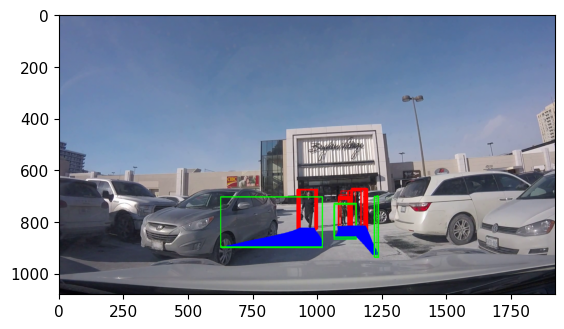

In [536]:
RGB_img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()

In [537]:
# %time

# model.eval()

# input_x = input_x.to(cfg.DEVICE)
# input_x = input_x.unsqueeze(0)
# cur_pos = input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM]
# pred_traj, pred_goal = predict(model, input_x, cur_pos=input_x[-1, :cfg.MODEL.DEC_OUTPUT_DIM])
# pred_traj = pred_traj.detach().to('cpu').numpy()
# pred_goal = pred_goal.detach().to('cpu').numpy()


In [538]:
pred_goal = pred_goal * (_max - _min) + _min
pred_traj = pred_traj * (_max - _min) + _min

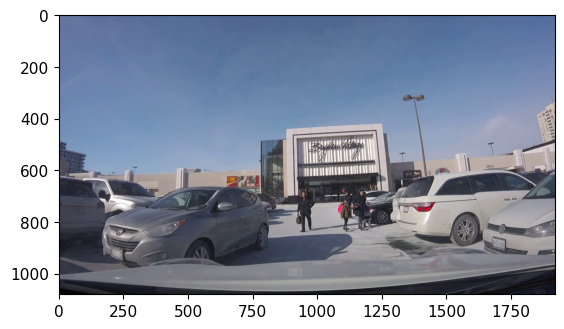

In [539]:
cv_image = cv2.imread(f"../data/JAAD/images/video_0005/00061.png")
for test in pred_traj:
    for j, traj in enumerate(test):
        for i, box in enumerate(traj):
            # if i == len(traj) - 1:
            # rect = cv2.boundingRect(testArray)
            x, y, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
            cv2.rectangle(cv_image, (x, y), (x + w, y + h), (255, 0, 0), 1)
            break

for goal in pred_goal:
    for i, location in enumerate(goal):
        # if i == len(goal) - 1:
        x, y, w, h = int(location[0]), int(location[1]), int(location[2]), int(location[3])
        cv2.rectangle(cv_image, (x, y), (int(x + w) , int(y + h)), (0, 255, 0), 2)
        break

RGB_img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()